# HAR Improved Pipeline
- Accelerometer + Gyroscope data
- No overlapping windows (step = window_size)
- 152 features (76 accel + 76 gyro)
- Stratified random split (within-subject)
- XGBoost + Random Forest with feature importance

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Configuration

In [2]:
# ADJUST THESE AS NEEDED
PATH = Path("/data0/HAR-datasets/PLHI Data for All Trial Subjects-20250212T053126Z-001/PLHI Data for All Trial Subjects")

SAMPLING_RATE = 50  # Hz - adjust if different
WINDOW_SEC = 2      # 2-second windows
WINDOW_SIZE = SAMPLING_RATE * WINDOW_SEC  # 100 samples for 50Hz
STEP = WINDOW_SIZE  # NO OVERLAP

print(f"Window: {WINDOW_SEC}s ({WINDOW_SIZE} samples)")
print(f"Step: {STEP} (no overlap)")

Window: 2s (100 samples)
Step: 100 (no overlap)


## Data Loading

In [3]:
def load_subject_data(subject_num):
    """Load accelerometer AND gyroscope data for one subject"""
    subject_dir = PATH / f"Subject {subject_num}"
    
    accel_data, gyro_data, labels = [], [], []
    
    for activity_dir in sorted(subject_dir.iterdir()):
        if activity_dir.is_dir():
            act_num = int(activity_dir.name.split()[-1])
            
            acc_file = activity_dir / "WEAR_ACG.csv"
            gyro_file = activity_dir / "WEAR_GYRO.csv"  
            
            if acc_file.exists():
                # Load accelerometer
                df_acc = pd.read_csv(acc_file, sep=';')
                for col in ['x', 'y', 'z']:
                    df_acc[col] = pd.to_numeric(df_acc[col], errors='coerce')
                df_acc = df_acc.dropna(subset=['x', 'y', 'z'])
                
                # Load gyroscope (if exists)
                if gyro_file.exists():
                    df_gyro = pd.read_csv(gyro_file, sep=';')
                    for col in ['x', 'y', 'z']:
                        df_gyro[col] = pd.to_numeric(df_gyro[col], errors='coerce')
                    df_gyro = df_gyro.dropna(subset=['x', 'y', 'z'])
                    
                    # Align lengths
                    min_len = min(len(df_acc), len(df_gyro))
                    acc_xyz = df_acc[['x', 'y', 'z']].values[:min_len]
                    gyro_xyz = df_gyro[['x', 'y', 'z']].values[:min_len]
                else:
                    # No gyro - fill with zeros
                    acc_xyz = df_acc[['x', 'y', 'z']].values
                    gyro_xyz = np.zeros_like(acc_xyz)
                    print(f"Warning: No gyro file for Subject {subject_num}, Activity {act_num}")
                
                accel_data.append(acc_xyz)
                gyro_data.append(gyro_xyz)
                labels.append(np.full(len(acc_xyz), act_num))
    
    return np.vstack(accel_data), np.vstack(gyro_data), np.hstack(labels)

In [4]:
# Load all subjects
all_accel, all_gyro, all_labels, all_subjects = [], [], [], []

for subj in range(1, 7):
    acc, gyro, labels = load_subject_data(subj)
    all_accel.append(acc)
    all_gyro.append(gyro)
    all_labels.append(labels)
    all_subjects.append(np.full(len(labels), subj))
    print(f"Subject {subj}: {len(acc):,} samples")

X_acc = np.vstack(all_accel)
X_gyro = np.vstack(all_gyro)
y_all = np.hstack(all_labels)
subj_all = np.hstack(all_subjects)

print(f"\nTotal raw samples: {len(X_acc):,}")
print(f"Activities: {np.unique(y_all)}")

Subject 1: 290,859 samples
Subject 2: 265,558 samples
Subject 3: 291,122 samples
Subject 4: 271,735 samples
Subject 5: 64,970 samples
Subject 6: 265,840 samples

Total raw samples: 1,450,084
Activities: [ 1  2  3  4  5  6  7  8  9 10]


## Feature Extraction (76 features per sensor = 152 total)

In [5]:
def extract_features_single_sensor(window):
    """
    Extract 76 features from a single sensor (3-axis) window
    
    Time domain: 12 features × 3 axes = 36
    Frequency domain: 8 features × 3 axes = 24  
    Cross-axis/Magnitude: 16 features
    Total: 76
    """
    features = []
    x, y, z = window[:, 0], window[:, 1], window[:, 2]
    
    # ---- TIME DOMAIN (12 per axis × 3 = 36) ----
    for axis_data in [x, y, z]:
        features.extend([
            np.mean(axis_data),                          # 1. Mean
            np.std(axis_data),                           # 2. Std
            np.min(axis_data),                           # 3. Min
            np.max(axis_data),                           # 4. Max
            np.median(axis_data),                        # 5. Median
            np.percentile(axis_data, 25),                # 6. Q25
            np.percentile(axis_data, 75),                # 7. Q75
            np.percentile(axis_data, 75) - np.percentile(axis_data, 25),  # 8. IQR
            skew(axis_data),                             # 9. Skewness
            kurtosis(axis_data),                         # 10. Kurtosis
            np.sqrt(np.mean(axis_data**2)),              # 11. RMS
            np.sum(np.diff(np.sign(axis_data)) != 0),    # 12. Zero crossing rate
        ])
    
    # ---- FREQUENCY DOMAIN (8 per axis × 3 = 24) ----
    for axis_data in [x, y, z]:
        fft_vals = np.abs(fft(axis_data))[:len(axis_data)//2]
        freqs = np.fft.fftfreq(len(axis_data), 1/SAMPLING_RATE)[:len(axis_data)//2]
        
        fft_sum = np.sum(fft_vals) + 1e-10
        
        features.extend([
            np.mean(fft_vals),                           # 1. FFT mean
            np.max(fft_vals),                            # 2. FFT max
            np.sum(fft_vals**2),                         # 3. FFT energy
            freqs[np.argmax(fft_vals)] if len(fft_vals) > 0 else 0,  # 4. Dominant frequency
            -np.sum((fft_vals/fft_sum) * np.log(fft_vals/fft_sum + 1e-10)),  # 5. Spectral entropy
            np.sum(freqs * fft_vals) / fft_sum,          # 6. Mean frequency (weighted)
            np.sqrt(np.sum((freqs**2) * fft_vals) / fft_sum),  # 7. Frequency std
            np.sum(fft_vals[:len(fft_vals)//4]) / fft_sum,     # 8. Low freq energy ratio
        ])
    
    # ---- CROSS-AXIS / MAGNITUDE (16) ----
    magnitude = np.sqrt(x**2 + y**2 + z**2)
    
    features.extend([
        np.mean(magnitude),                              # 1. Magnitude mean
        np.std(magnitude),                               # 2. Magnitude std
        np.max(magnitude),                               # 3. Magnitude max
        np.min(magnitude),                               # 4. Magnitude min
        np.median(magnitude),                            # 5. Magnitude median
        skew(magnitude),                                 # 6. Magnitude skewness
        kurtosis(magnitude),                             # 7. Magnitude kurtosis
        np.sqrt(np.mean(magnitude**2)),                  # 8. Magnitude RMS
        np.mean(np.abs(x) + np.abs(y) + np.abs(z)),      # 9. SMA (Signal Magnitude Area)
        np.sum(x**2 + y**2 + z**2),                      # 10. Total energy
        np.corrcoef(x, y)[0, 1] if np.std(x) > 0 and np.std(y) > 0 else 0,  # 11. Corr X-Y
        np.corrcoef(x, z)[0, 1] if np.std(x) > 0 and np.std(z) > 0 else 0,  # 12. Corr X-Z
        np.corrcoef(y, z)[0, 1] if np.std(y) > 0 and np.std(z) > 0 else 0,  # 13. Corr Y-Z
        np.mean(x**2 + z**2),                            # 14. Horizontal energy (X² + Z²)
        np.mean(np.abs(np.diff(magnitude))),             # 15. Magnitude jerk
        np.max(magnitude) - np.min(magnitude),           # 16. Magnitude range
    ])
    
    return features

In [6]:
def create_windows_no_overlap(accel, gyro, labels, subjects):
    """
    Create non-overlapping windows with 152 features (76 accel + 76 gyro)
    """
    all_features, all_labels, all_subjects = [], [], []
    
    n_windows = (len(accel) - WINDOW_SIZE) // STEP + 1
    
    for i in range(n_windows):
        start = i * STEP
        end = start + WINDOW_SIZE
        
        acc_window = accel[start:end]
        gyro_window = gyro[start:end]
        
        # Extract 76 + 76 = 152 features
        acc_feats = extract_features_single_sensor(acc_window)
        gyro_feats = extract_features_single_sensor(gyro_window)
        
        all_features.append(acc_feats + gyro_feats)
        all_labels.append(labels[end - 1])
        all_subjects.append(subjects[end - 1])
    
    return np.array(all_features), np.array(all_labels), np.array(all_subjects)

In [7]:
# Extract features
print("Extracting features (no overlap)...")
X_feat, y_feat, subj_feat = create_windows_no_overlap(X_acc, X_gyro, y_all, subj_all)

# Handle NaN/Inf
X_feat = np.nan_to_num(X_feat, nan=0, posinf=0, neginf=0)

print(f"Windows: {len(X_feat):,}")
print(f"Features per window: {X_feat.shape[1]}")
print(f"Activity distribution: {np.bincount(y_feat.astype(int))}")

Extracting features (no overlap)...


/tmp/ipykernel_2027946/2726482585.py:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(axis_data),                             # 9. Skewness
/tmp/ipykernel_2027946/2726482585.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(axis_data),                         # 10. Kurtosis
/tmp/ipykernel_2027946/2726482585.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(magnitude),                                 # 6. Magnitude skewness
/tmp/ipykernel_2027946/2726482585.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are

Windows: 14,500
Features per window: 152
Activity distribution: [   0 1262 1661 1673 1612 1510 1320 1526 1396 1361 1179]


## Feature Names (for importance analysis)

In [8]:
def get_feature_names():
    """Generate feature names for interpretability"""
    time_feats = ['mean', 'std', 'min', 'max', 'median', 'q25', 'q75', 'iqr', 
                  'skew', 'kurtosis', 'rms', 'zcr']
    freq_feats = ['fft_mean', 'fft_max', 'fft_energy', 'dom_freq', 
                  'spectral_entropy', 'mean_freq', 'freq_std', 'low_freq_ratio']
    mag_feats = ['mag_mean', 'mag_std', 'mag_max', 'mag_min', 'mag_median',
                 'mag_skew', 'mag_kurtosis', 'mag_rms', 'sma', 'total_energy',
                 'corr_xy', 'corr_xz', 'corr_yz', 'horiz_energy', 'mag_jerk', 'mag_range']
    
    names = []
    for sensor in ['acc', 'gyro']:
        for axis in ['x', 'y', 'z']:
            for feat in time_feats:
                names.append(f"{sensor}_{axis}_{feat}")
        for axis in ['x', 'y', 'z']:
            for feat in freq_feats:
                names.append(f"{sensor}_{axis}_{feat}")
        for feat in mag_feats:
            names.append(f"{sensor}_{feat}")
    
    return names

feature_names = get_feature_names()
print(f"Total feature names: {len(feature_names)}")

Total feature names: 152


## Within-Subject Evaluation (Stratified Split)
No data leakage - using stratified random split with non-overlapping windows

In [11]:
from sklearn.preprocessing import LabelEncoder

print("Within-Subject Evaluation (Stratified Split)")
print("=" * 50)

# --- GLOBAL FIX: Ensure labels start at 0 ---
if np.min(y_feat) == 1:
    print("Adjusting global labels from 1-10 to 0-9...")
    y_feat = y_feat - 1

rf_results, xgb_results = [], []
all_y_true, all_y_pred_rf, all_y_pred_xgb = [], [], []

for test_subj in range(1, 7):
    mask = subj_feat == test_subj
    X_subj = X_feat[mask]
    y_subj = y_feat[mask]
    
    # Stratified 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(
        X_subj, y_subj, test_size=0.2, random_state=42, stratify=y_subj
    )
    
    # --- RF (Handles missing classes fine) ---
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_acc = rf.score(X_test, y_test)
    rf_results.append(rf_acc)
    
    # --- XGBOOST ROBUST BLOCK ---
    # 1. Remap local labels to 0..N-1 for XGBoost (handles Subject 5 missing Activity 0)
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    # 2. Train XGBoost on encoded labels
    xgb_model = xgb.XGBClassifier(
        n_estimators=200, 
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train_encoded)
    
    # 3. Get predictions and map them BACK to global IDs
    xgb_pred_encoded = xgb_model.predict(X_test)
    xgb_pred_real = le.inverse_transform(xgb_pred_encoded)
    
    # 4. Calculate accuracy using the real labels
    xgb_acc = accuracy_score(y_test, xgb_pred_real)
    xgb_results.append(xgb_acc)
    
    # Collect predictions (using real global IDs)
    all_y_true.extend(y_test)
    all_y_pred_rf.extend(rf.predict(X_test))
    all_y_pred_xgb.extend(xgb_pred_real)
    
    print(f"Subject {test_subj}: RF={rf_acc:.3f} | XGB={xgb_acc:.3f} (Classes: {len(le.classes_)})")

print(f"\nMean: RF={np.mean(rf_results):.3f} ± {np.std(rf_results):.3f} | XGB={np.mean(xgb_results):.3f} ± {np.std(xgb_results):.3f}")

Within-Subject Evaluation (Stratified Split)
Subject 1: RF=0.974 | XGB=0.973 (Classes: 10)
Subject 2: RF=0.951 | XGB=0.945 (Classes: 10)
Subject 3: RF=0.959 | XGB=0.971 (Classes: 10)
Subject 4: RF=0.978 | XGB=0.982 (Classes: 10)
Subject 5: RF=0.977 | XGB=0.985 (Classes: 4)
Subject 6: RF=0.976 | XGB=0.970 (Classes: 10)

Mean: RF=0.969 ± 0.010 | XGB=0.971 ± 0.013


In [12]:
# Classification Report (Within-Subject XGBoost)
print("Classification Report (Within-Subject XGBoost)")
print("=" * 50)
print(classification_report(all_y_true, all_y_pred_xgb))

Classification Report (Within-Subject XGBoost)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       254
           1       0.95      0.98      0.96       333
           2       0.97      0.97      0.97       334
           3       0.97      0.97      0.97       323
           4       0.97      0.96      0.97       303
           5       0.97      0.96      0.96       264
           6       0.95      0.99      0.97       306
           7       0.99      0.97      0.98       279
           8       0.96      0.94      0.95       271
           9       0.99      0.98      0.99       236

    accuracy                           0.97      2903
   macro avg       0.97      0.97      0.97      2903
weighted avg       0.97      0.97      0.97      2903



## LOSO Cross-Subject Evaluation

In [13]:
print("LOSO Cross-Subject Evaluation")
print("=" * 50)

loso_rf, loso_xgb = [], []
loso_y_true, loso_y_pred_xgb = [], []

for test_subj in range(1, 7):
    train_mask = subj_feat != test_subj
    test_mask = subj_feat == test_subj
    
    X_train, y_train = X_feat[train_mask], y_feat[train_mask]
    X_test, y_test = X_feat[test_mask], y_feat[test_mask]
    
    # RF
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    loso_rf.append(rf.score(X_test, y_test))
    
    # XGB
    xgb_model = xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, n_jobs=-1, eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)
    loso_xgb.append(xgb_model.score(X_test, y_test))
    
    loso_y_true.extend(y_test)
    loso_y_pred_xgb.extend(xgb_model.predict(X_test))
    
    print(f"Test Subject {test_subj}: RF={loso_rf[-1]:.3f} | XGB={loso_xgb[-1]:.3f}")

print(f"\nLOSO Mean: RF={np.mean(loso_rf):.3f} ± {np.std(loso_rf):.3f} | XGB={np.mean(loso_xgb):.3f} ± {np.std(loso_xgb):.3f}")

LOSO Cross-Subject Evaluation
Test Subject 1: RF=0.350 | XGB=0.344
Test Subject 2: RF=0.225 | XGB=0.223
Test Subject 3: RF=0.396 | XGB=0.364
Test Subject 4: RF=0.269 | XGB=0.240
Test Subject 5: RF=0.314 | XGB=0.311
Test Subject 6: RF=0.357 | XGB=0.340

LOSO Mean: RF=0.318 ± 0.057 | XGB=0.304 ± 0.054


In [14]:
# Classification Report (LOSO XGBoost)
print("Classification Report (LOSO XGBoost)")
print("=" * 50)
print(classification_report(loso_y_true, loso_y_pred_xgb))

Classification Report (LOSO XGBoost)
              precision    recall  f1-score   support

           0       0.18      0.14      0.16      1262
           1       0.12      0.10      0.11      1661
           2       0.40      0.45      0.42      1673
           3       0.25      0.34      0.29      1612
           4       0.33      0.38      0.36      1510
           5       0.22      0.20      0.21      1320
           6       0.28      0.22      0.25      1526
           7       0.43      0.50      0.46      1396
           8       0.24      0.26      0.25      1361
           9       0.57      0.47      0.52      1179

    accuracy                           0.30     14500
   macro avg       0.30      0.31      0.30     14500
weighted avg       0.30      0.30      0.30     14500



In [15]:
print("LOSO Cross-Subject Evaluation")
print("=" * 50)

loso_rf, loso_xgb = [], []
loso_y_true, loso_y_pred_xgb = [], []

for test_subj in range(1, 7):
    train_mask = subj_feat != test_subj
    test_mask = subj_feat == test_subj
    
    X_train, y_train = X_feat[train_mask], y_feat[train_mask]
    X_test, y_test = X_feat[test_mask], y_feat[test_mask]
    
    # --- RF (Robust to missing classes) ---
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    loso_rf.append(rf.score(X_test, y_test))
    
    # --- XGBOOST ROBUST BLOCK ---
    # 1. Remap training labels to 0..N-1 (Safety net for missing training classes)
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, n_jobs=-1, eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train_encoded)
    
    # 2. Predict and inverse transform
    # Note: We must handle cases where the model predicts a class that wasn't in training
    # (Unlikely in LOSO, but good practice). 
    # For LOSO, the test set classes SHOULD exist in training.
    
    xgb_pred_encoded = xgb_model.predict(X_test)
    xgb_pred_real = le.inverse_transform(xgb_pred_encoded)
    
    loso_xgb.append(accuracy_score(y_test, xgb_pred_real))
    
    loso_y_true.extend(y_test)
    loso_y_pred_xgb.extend(xgb_pred_real)
    
    print(f"Test Subject {test_subj}: RF={loso_rf[-1]:.3f} | XGB={loso_xgb[-1]:.3f} (Train classes: {len(le.classes_)})")

print(f"\nLOSO Mean: RF={np.mean(loso_rf):.3f} ± {np.std(loso_rf):.3f} | XGB={np.mean(loso_xgb):.3f} ± {np.std(loso_xgb):.3f}")

LOSO Cross-Subject Evaluation
Test Subject 1: RF=0.350 | XGB=0.344 (Train classes: 10)
Test Subject 2: RF=0.225 | XGB=0.223 (Train classes: 10)
Test Subject 3: RF=0.396 | XGB=0.364 (Train classes: 10)
Test Subject 4: RF=0.269 | XGB=0.240 (Train classes: 10)
Test Subject 5: RF=0.314 | XGB=0.311 (Train classes: 10)
Test Subject 6: RF=0.357 | XGB=0.340 (Train classes: 10)

LOSO Mean: RF=0.318 ± 0.057 | XGB=0.304 ± 0.054


## Feature Importance (XGBoost)

Training final XGBoost on ALL data for feature importance...

Top 20 Global Features (Explains Within-Subject Accuracy):
               feature  importance
37       acc_x_fft_max    0.050353
12          acc_y_mean    0.030687
38    acc_x_fft_energy    0.029935
3            acc_x_max    0.027330
27           acc_z_max    0.023668
14           acc_y_min    0.020825
18           acc_y_q75    0.019866
22           acc_y_rms    0.019104
62         acc_mag_max    0.018289
46    acc_y_fft_energy    0.016850
16        acc_y_median    0.016027
2            acc_x_min    0.015617
144           gyro_sma    0.015116
10           acc_x_rms    0.015106
15           acc_y_max    0.014834
122  gyro_y_fft_energy    0.014689
5            acc_x_q25    0.014585
0           acc_x_mean    0.014529
67         acc_mag_rms    0.014352
143       gyro_mag_rms    0.013541


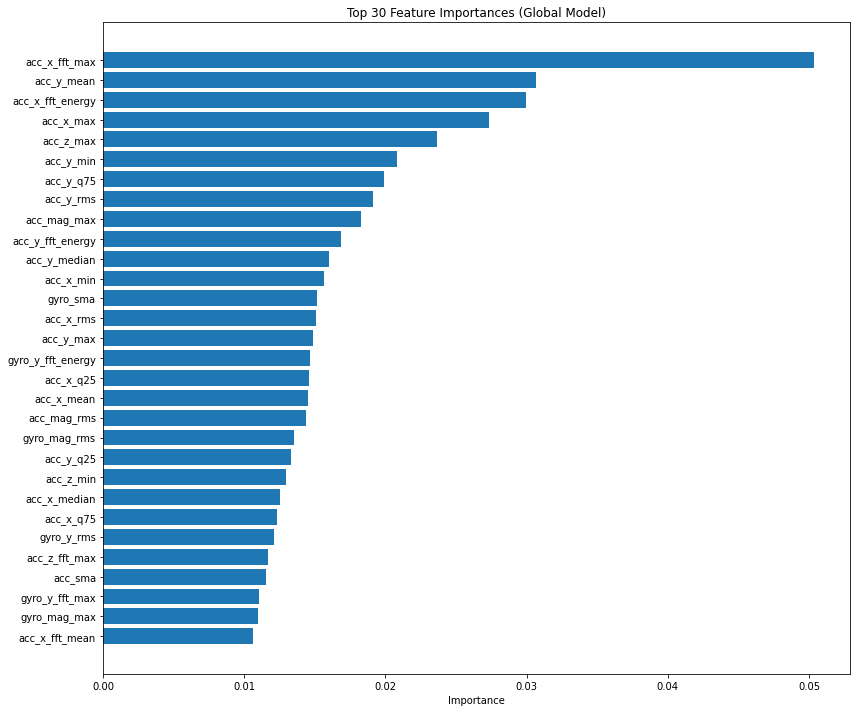

Saved: xgb_model.pkl


In [20]:
# --- Feature Importance (Global / Within-Subject) ---
# This trains on ALL data (subjects 1-6 mixed).
# It explains which features the model uses to get 97% accuracy.

print("Training final XGBoost on ALL data for feature importance...")

# 1. Train on everything (X_feat, y_feat)
final_xgb = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.1,
    random_state=42, 
    n_jobs=-1, 
    eval_metric='mlogloss'
)
final_xgb.fit(X_feat, y_feat)

# 2. Get Importance
importance = final_xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Global Features (Explains Within-Subject Accuracy):")
print(importance_df.head(20))

# 3. Plot
plt.figure(figsize=(12, 10))
top_30 = importance_df.head(30)
plt.barh(range(len(top_30)), top_30['importance'].values)
plt.yticks(range(len(top_30)), top_30['feature'].values)
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances (Global Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. Save Model
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(final_xgb, f)
print("Saved: xgb_model.pkl")

## Confusion Matrix

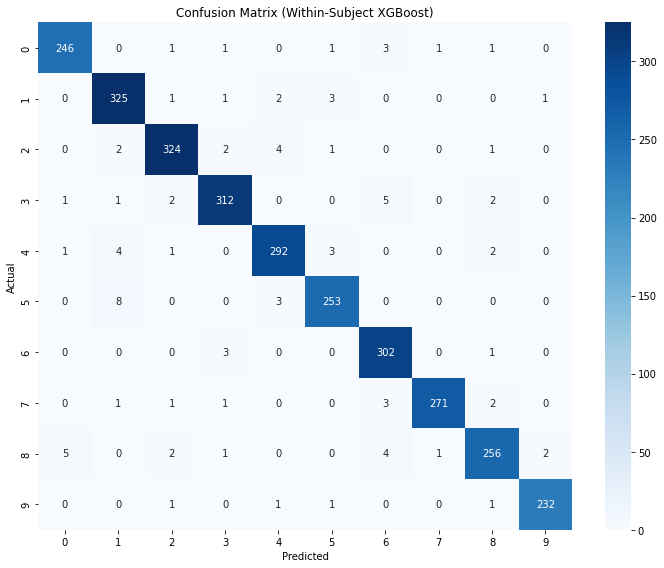

In [18]:
# Confusion matrix for within-subject
cm = confusion_matrix(all_y_true, all_y_pred_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Within-Subject XGBoost)')
plt.tight_layout()
plt.show()

## Summary

In [19]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Window: {WINDOW_SEC}s ({WINDOW_SIZE} samples) | No overlap")
print(f"Features: {X_feat.shape[1]} (76 accel + 76 gyro)")
print(f"Total windows: {len(X_feat):,}")
print()
print("Within-Subject (Stratified Split):")
print(f"  RF:  {np.mean(rf_results):.3f} ± {np.std(rf_results):.3f}")
print(f"  XGB: {np.mean(xgb_results):.3f} ± {np.std(xgb_results):.3f}")
print()
print("Cross-Subject (LOSO):")
print(f"  RF:  {np.mean(loso_rf):.3f} ± {np.std(loso_rf):.3f}")
print(f"  XGB: {np.mean(loso_xgb):.3f} ± {np.std(loso_xgb):.3f}")
print("=" * 60)

SUMMARY
Window: 2s (100 samples) | No overlap
Features: 152 (76 accel + 76 gyro)
Total windows: 14,500

Within-Subject (Stratified Split):
  RF:  0.969 ± 0.010
  XGB: 0.971 ± 0.013

Cross-Subject (LOSO):
  RF:  0.318 ± 0.057
  XGB: 0.304 ± 0.054


In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

print("Within-Subject Evaluation (5-Fold Stratified CV)")
print("=" * 50)

# --- GLOBAL FIX: Ensure labels start at 0 ---
if np.min(y_feat) == 1:
    print("Adjusting global labels from 1-10 to 0-9...")
    y_feat = y_feat - 1

rf_results, xgb_results = [], []
all_y_true, all_y_pred_rf, all_y_pred_xgb = [], [], []

for test_subj in range(1, 7):
    mask = subj_feat == test_subj
    X_subj = X_feat[mask]
    y_subj = y_feat[mask]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    subj_rf_scores, subj_xgb_scores = [], []
    
    for train_idx, test_idx in skf.split(X_subj, y_subj):
        X_train, X_test = X_subj[train_idx], X_subj[test_idx]
        y_train, y_test = y_subj[train_idx], y_subj[test_idx]
        
        # --- RF ---
        rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        subj_rf_scores.append(rf.score(X_test, y_test))
        
        # --- XGBOOST with LabelEncoder ---
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        
        xgb_model = xgb.XGBClassifier(
            n_estimators=200, 
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            eval_metric='mlogloss'
        )
        xgb_model.fit(X_train, y_train_encoded)
        
        xgb_pred_encoded = xgb_model.predict(X_test)
        xgb_pred_real = le.inverse_transform(xgb_pred_encoded)
        subj_xgb_scores.append(accuracy_score(y_test, xgb_pred_real))
        
        # Collect predictions (last fold only for classification report)
        all_y_true.extend(y_test)
        all_y_pred_rf.extend(rf.predict(X_test))
        all_y_pred_xgb.extend(xgb_pred_real)
    
    rf_results.append(np.mean(subj_rf_scores))
    xgb_results.append(np.mean(subj_xgb_scores))
    
    print(f"Subject {test_subj}: RF={np.mean(subj_rf_scores):.3f}±{np.std(subj_rf_scores):.3f} | XGB={np.mean(subj_xgb_scores):.3f}±{np.std(subj_xgb_scores):.3f} (Classes: {len(le.classes_)})")

print(f"\nMean: RF={np.mean(rf_results):.3f} ± {np.std(rf_results):.3f} | XGB={np.mean(xgb_results):.3f} ± {np.std(xgb_results):.3f}")


Within-Subject Evaluation (5-Fold Stratified CV)
Subject 1: RF=0.981±0.003 | XGB=0.980±0.005 (Classes: 10)
Subject 2: RF=0.959±0.008 | XGB=0.954±0.012 (Classes: 10)
Subject 3: RF=0.964±0.009 | XGB=0.959±0.011 (Classes: 10)
Subject 4: RF=0.974±0.003 | XGB=0.973±0.007 (Classes: 10)
Subject 5: RF=0.991±0.008 | XGB=0.980±0.012 (Classes: 4)
Subject 6: RF=0.964±0.006 | XGB=0.960±0.006 (Classes: 10)

Mean: RF=0.972 ± 0.011 | XGB=0.968 ± 0.010


In [23]:
rf.score(X_test, y_test)       # ← TESTING
xgb_model.predict(X_test)      # ← TESTING

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 1, 1, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4, 4, 4, 4, 4, 9, 6, 6, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,